In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
from anndata import AnnData
import scanpy.external as sce


In [2]:
def createAnndata(sample,name,outdir):
    exp_df = pd.read_csv(str(outdir)+"/"+str(name)+"_normalized_counts.csv", index_col=0)
    genes_df = pd.read_csv(str(outdir)+"/cellranger/"+str(sample)+"/outs/raw_feature_bc_matrix/genes.tsv",sep="\t",header=None)
    annot = pd.read_csv(str(outdir)+"/"+str(name)+"_numis.csv", index_col=0)
    annot["sample_id"] = annot["region"] + "_" + annot["repli"].map(str)
    exp_df.columns = genes_df[1]
    adata = AnnData(exp_df)
    adata.var.index.name = "genes"
    adata.var_names_make_unique()
    return(adata)

In [3]:
adata1 = createAnndata("LB1_BYR819A1","macula1","/ihome/lbyrne/mej85/pgtb_human_retina_explant/analysis/")
adata2 = createAnndata("LB4_BYR819A4","macula2","/ihome/lbyrne/mej85/pgtb_human_retina_explant/analysis/")


/bgfs/lbyrne/anaconda3/envs/scaavengr_env/lib/python3.7/site-packages/anndata/utils.py:141: UserWarning: X converted to numpy array with dtype float64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adata = adata1.concatenate(adata2,batch_categories=['macula1','macula2'])
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata

AnnData object with n_obs × n_vars = 4814 × 36601
    obs: 'batch'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

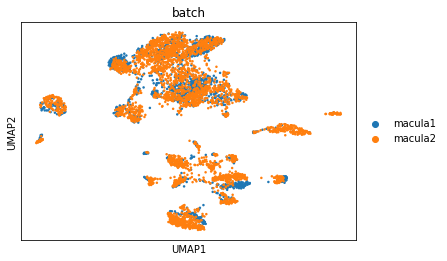

In [5]:
sc.pl.umap(adata,color="batch")

In [6]:
sce.pp.harmony_integrate(adata, 'batch')
'X_pca_harmony' in adata.obsm

2023-10-03 15:36:43,801 - harmonypy - INFO - Iteration 1 of 10
2023-10-03 15:36:44,814 - harmonypy - INFO - Iteration 2 of 10
2023-10-03 15:36:45,573 - harmonypy - INFO - Iteration 3 of 10
2023-10-03 15:36:46,429 - harmonypy - INFO - Iteration 4 of 10
2023-10-03 15:36:47,213 - harmonypy - INFO - Iteration 5 of 10
2023-10-03 15:36:47,603 - harmonypy - INFO - Iteration 6 of 10
2023-10-03 15:36:47,860 - harmonypy - INFO - Iteration 7 of 10
2023-10-03 15:36:48,119 - harmonypy - INFO - Iteration 8 of 10
2023-10-03 15:36:48,381 - harmonypy - INFO - Iteration 9 of 10
2023-10-03 15:36:48,639 - harmonypy - INFO - Iteration 10 of 10
2023-10-03 15:36:48,894 - harmonypy - INFO - Converged after 10 iterations


True

In [7]:
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']
sc.pp.neighbors(adata)
sc.tl.umap(adata)


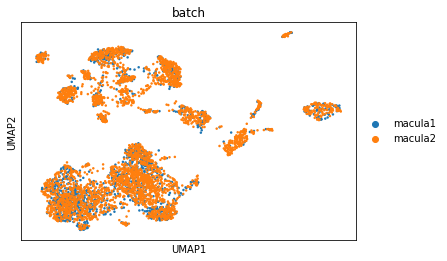

In [8]:
sc.pl.umap(adata,color="batch")

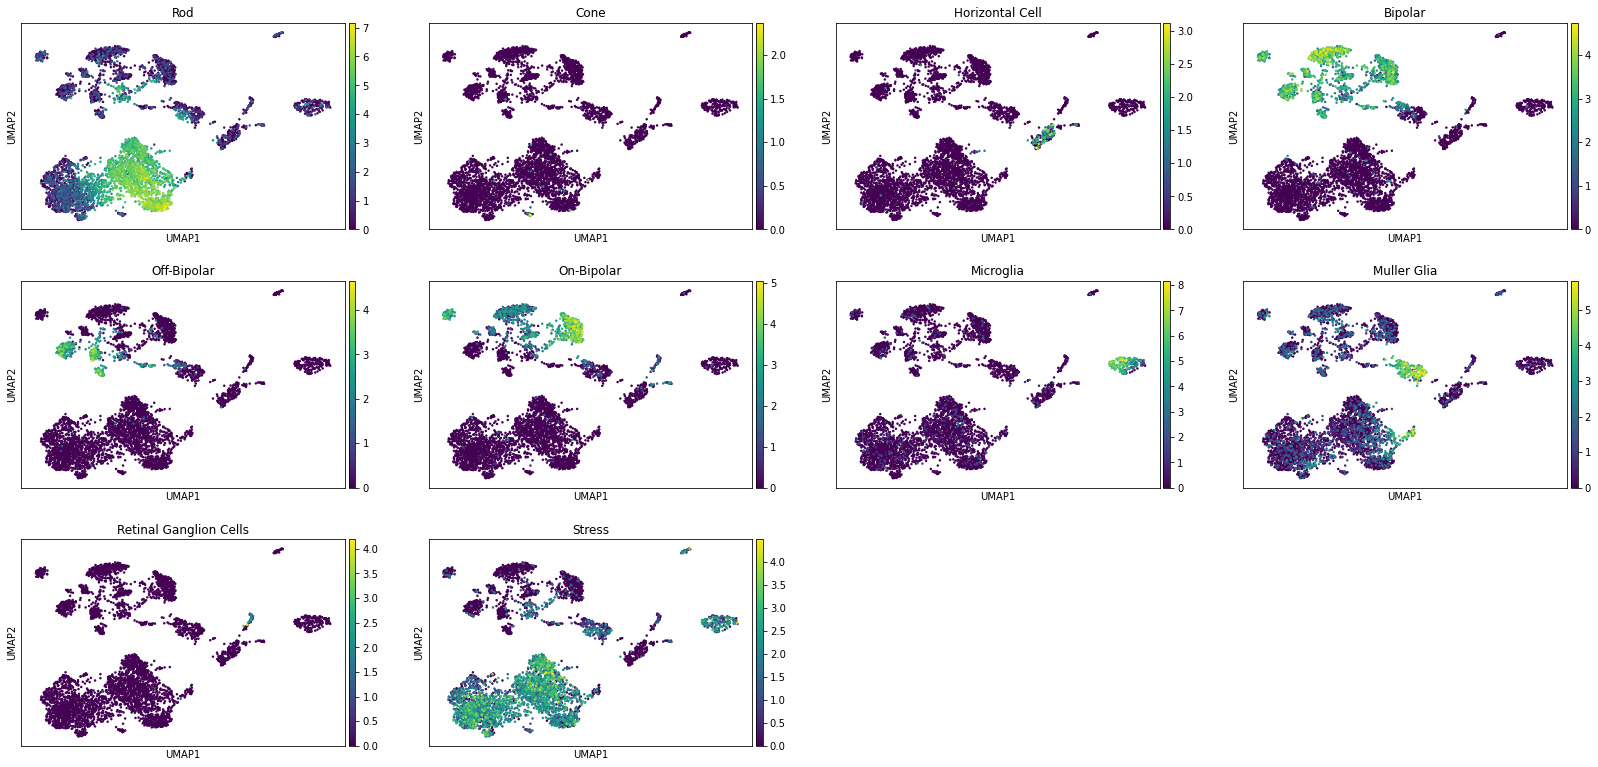

In [9]:
sc.pl.umap(adata,color=["RHO","GNAT2","LHX1","TMEM215","GRIK1","ISL1","C1QA","RLBP1","SLC17A6","SOCS3"],
          title=["Rod","Cone","Horizontal Cell","Bipolar","Off-Bipolar","On-Bipolar","Microglia","Muller Glia",
                "Retinal Ganglion Cells","Stress"])

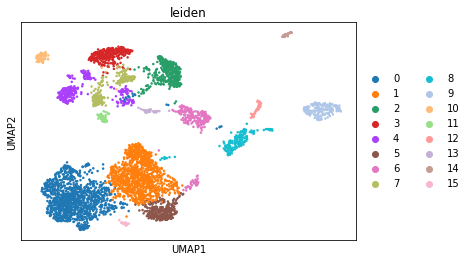

In [27]:
sc.tl.leiden(adata, resolution=0.3)
sc.pl.umap(adata,color="leiden")

In [28]:
# Starting gene marker DE analysis

import sys
sys.path.insert(0,'/ihome/lbyrne/mej85/git_repos/PGTB/')
from hyper_geometric_profiler import Local_Profiler
prof = Local_Profiler(fname="/bgfs/lbyrne/PGTB/resources/retina_markers.csv",ftype="retina")



In [29]:
cell_type_dict = {}
gene_names = [gene.lower().capitalize() for gene in adata.var_names]
uniq_clusts = np.unique(np.asarray(adata.obs["leiden"]))
for selected_clust in uniq_clusts:
    is_mark = [clust == selected_clust for clust in np.asarray(adata.obs["leiden"])]
    adata.obs["mark"] = pd.Categorical(
        values=is_mark,
        categories=[True, False])
    sc.tl.rank_genes_groups(adata, "mark")
    m_genes = [tup[0].lower().capitalize() for tup in adata.uns["rank_genes_groups"]["names"]]
    marker_genes = m_genes[:200]
    to_print = "CLUSTER: " + str(selected_clust)
    print(to_print)
    print("------------------------------------------------------------------------------")
    re_df = prof.local_profiler_results(marker_genes, .2, gene_names)
    print(re_df)
    if re_df.empty:
        cell_type_dict[selected_clust] = selected_clust
    else:
        cell_type_dict[selected_clust] =  re_df["label"].values[np.argmin(re_df["p_value"].values)]
        
        
# sc.tl.rank_genes_group will run diff expression analysis on RAW data by default (which we have saved as our normalized log counts)




CLUSTER: 0
------------------------------------------------------------------------------
Empty DataFrame
Columns: [p_value, label, query_match]
Index: []
CLUSTER: 1
------------------------------------------------------------------------------
        p_value        label                             query_match
0  8.283886e-18          Rod  Gngt1,Nr2e3,Sag,Nrl,Gnat1,Rho,Pdc,Gnb1
1  6.992167e-02  Off-Bipolar                             Rcvrn,Meis2
CLUSTER: 10
------------------------------------------------------------------------------
    p_value            label            query_match
0  0.040679             Cone           Tbx2,Ccdc136
1  0.000038  Bipolar general     Cabp5,Tmem215,Vsx2
2  0.000120       On-Bipolar  Isl1,Lmo4,Scn1b,Prkca
CLUSTER: 11
------------------------------------------------------------------------------
        p_value            label                    query_match
0  1.544035e-07  Bipolar general       Scn1a,Cabp5,Tmem215,Vsx2
1  9.846756e-02       On-Bipol

In [30]:
cell_type_dict

{'0': '0',
 '1': 'Rod',
 '10': 'Bipolar general',
 '11': 'Bipolar general',
 '12': 'Retinal Ganglion Cell',
 '13': 'Bipolar general',
 '14': 'Muller Glia',
 '15': 'Cone',
 '2': 'Bipolar general',
 '3': 'Bipolar general',
 '4': 'Off-Bipolar',
 '5': 'Rod',
 '6': 'Muller Glia',
 '7': 'Bipolar general',
 '8': 'Horizontal Cell',
 '9': 'Microglia'}

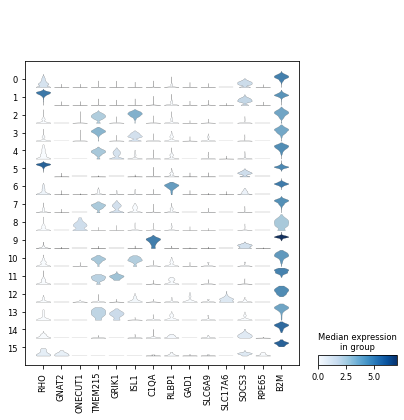

In [31]:
gene_markers = ["RHO","GNAT2","ONECUT1","TMEM215","GRIK1","ISL1",
                             "C1QA","RLBP1","GAD1","SLC6A9","SLC17A6","SOCS3","RPE65","B2M"]

sc.pl.stacked_violin(adata,gene_markers,groupby="leiden")

In [36]:
cell_type_dict = {'0': 'Degenerating PR',
 '1': 'Rod',
 '10': 'On-Bipolar',
 '11': 'Off-Bipolar',
 '12': 'Retinal Ganglion Cell',
 '13': 'Off-Bipolar',
 '14': 'Empty Droplets',
 '15': 'Cone',
 '2': 'On-Bipolar',
 '3': 'On-Bipolar',
 '4': 'Off-Bipolar',
 '5': 'Rod',
 '6': 'Muller Glia',
 '7': 'Off-Bipolar',
 '8': 'Horizontal Cell',
 '9': 'Microglia'}

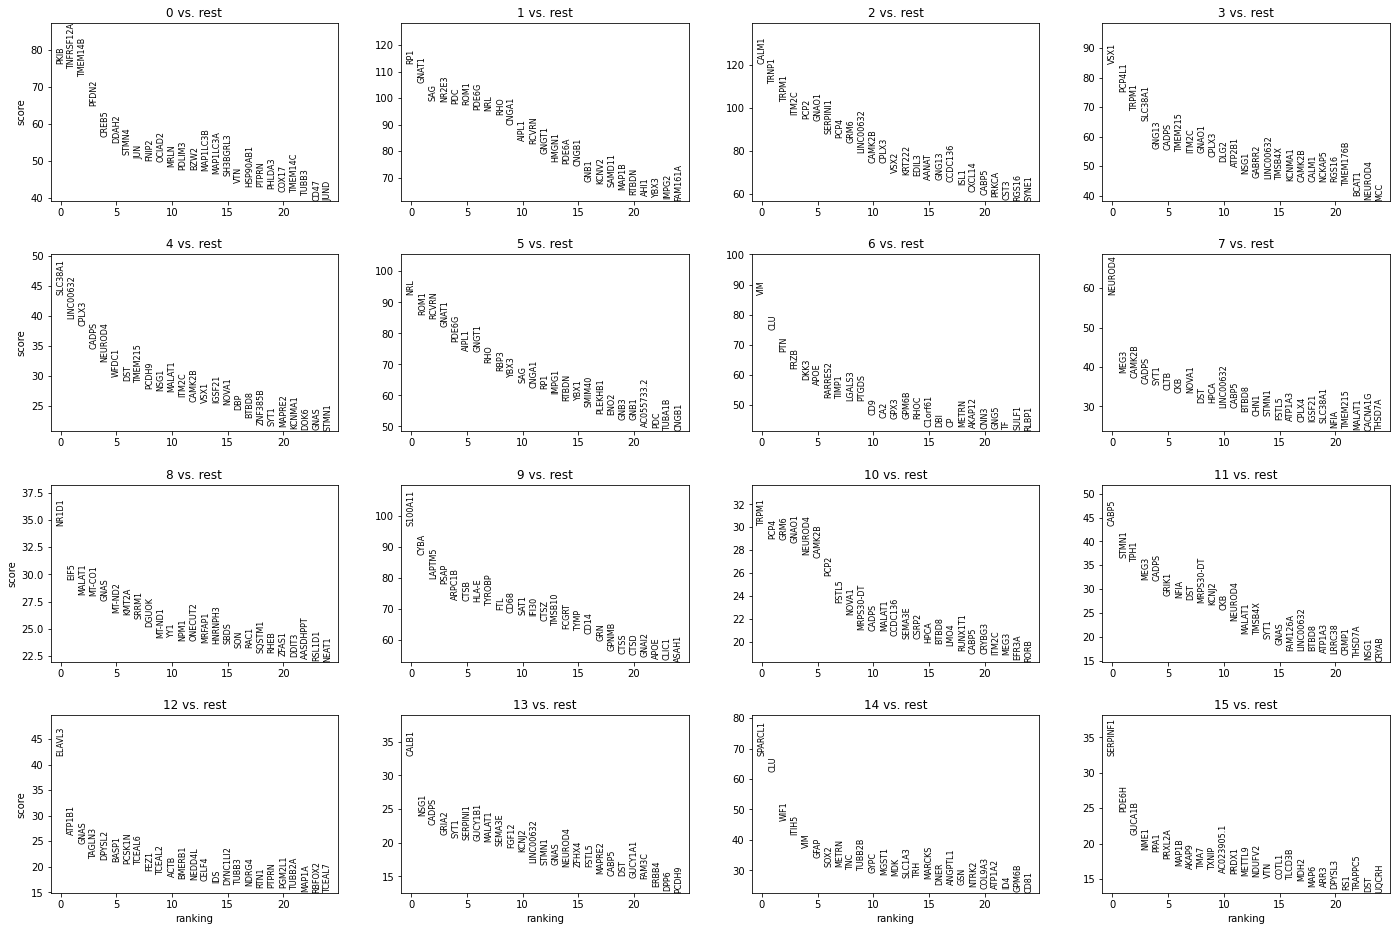

In [32]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

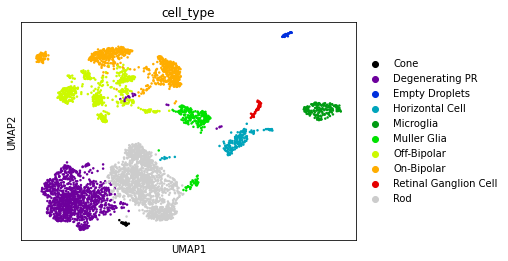

In [37]:
cell_types = ["Unknown" if cell_type_dict[cluster].isdigit() else cell_type_dict[cluster] for cluster in adata.obs["leiden"]]
adata.obs["cell_type"] = pd.Categorical(
            values=cell_types,
            categories=np.unique(cell_types))
sc.pl.umap(adata,color="cell_type", palette="nipy_spectral")

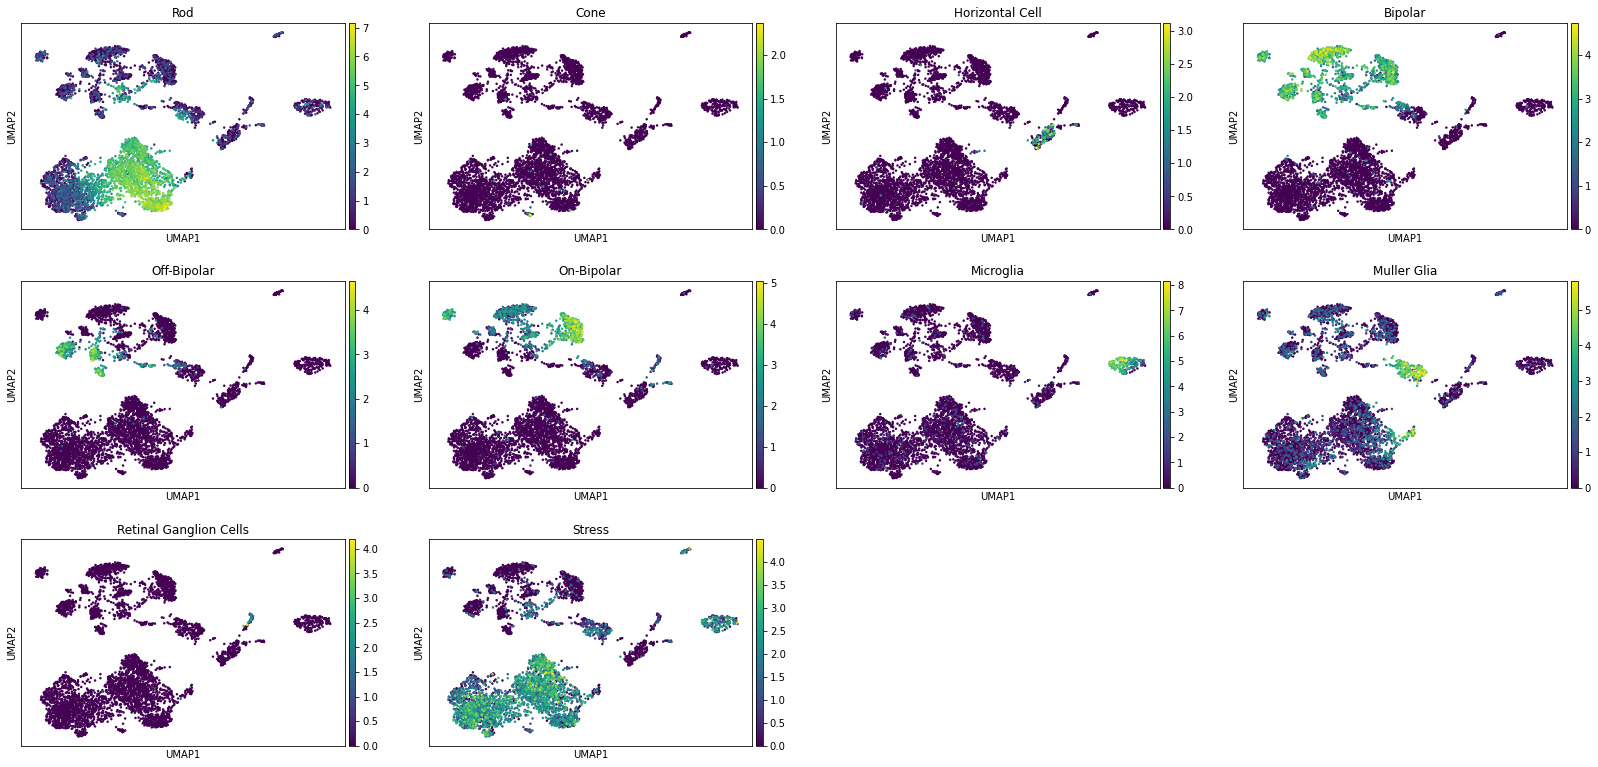

In [26]:
sc.pl.umap(adata,color=["RHO","GNAT2","LHX1","TMEM215","GRIK1","ISL1","C1QA","RLBP1","SLC17A6","SOCS3"],
          title=["Rod","Cone","Horizontal Cell","Bipolar","Off-Bipolar","On-Bipolar","Microglia","Muller Glia",
                "Retinal Ganglion Cells","Stress"])

In [39]:
adata.obs.head()

,batch,leiden,mark,cell_type
AAACCCAGTAAGGAGA-1_1_macula-macula1,macula1,5,False,Rod
AAACCCATCTAGGCCG-1_1_macula-macula1,macula1,0,False,Degenerating PR
AAACGAAGTGGCTCTG-1_1_macula-macula1,macula1,4,False,Off-Bipolar
AAAGGATCACGGTCTG-1_1_macula-macula1,macula1,0,False,Degenerating PR
AAAGGGCGTCATCCCT-1_1_macula-macula1,macula1,5,False,Rod


In [41]:
adata.obs.tail()

,batch,leiden,mark,cell_type
TTTGGTTTCGCAGTCG-1_2_macula-macula2,macula2,2,False,On-Bipolar
TTTGTTGGTAACTAAG-1_2_macula-macula2,macula2,6,False,Muller Glia
TTTGTTGGTCGAACAG-1_2_macula-macula2,macula2,1,False,Rod
TTTGTTGTCATGGTAC-1_2_macula-macula2,macula2,11,False,Off-Bipolar
TTTGTTGTCGAGTTGT-1_2_macula-macula2,macula2,11,False,Off-Bipolar


In [40]:
adata.write("/ihome/lbyrne/mej85/pgtb_human_retina_explant/analysis/macula_ann.h5ad")

In [47]:
####### IMPORTING GFP RESULTS ########

# GFP x cell matrix
gfp_df1=pd.read_csv("/ihome/lbyrne/mej85/pgtb_human_retina_explant/analysis/salmon_quant/LB1_BYR819A1_S1_gfp_cell_matrix.csv", sep=',', index_col=0)
#gfp_df2=pd.read_csv("/ihome/lbyrne/mej85/pgtb_human_retina_explant/analysis/salmon_quant/LB1_BYR819A1_S1_gfp_cell_matrix.csv", sep=',', index_col=0)

# balance of GFP barcodes in injection pool 
rep=pd.read_csv("/bgfs/lbyrne/PGTB/metadata/barcodes_representation.txt",sep="\t",index_col=0)

# read in key of GFP barcode to AAV variant
key=pd.read_csv("/bgfs/lbyrne/PGTB/resources/gfpbc_2_aav_key.csv",sep=",",index_col=0)

In [48]:
gfp_df1.head()

,Barcode1,Barcode10,Barcode11,Barcode12,Barcode13,Barcode14,Barcode15,Barcode16,Barcode17,Barcode18,...,Barcode27,Barcode29,Barcode3,Barcode30,Barcode4,Barcode5,Barcode6,Barcode7,Barcode8,Barcode9
AAAAAGACAATGAAAA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCATCTCCGCCA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAAGGGTCACAAGGG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAATCATTTTTTTTT,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACACATCTGCGGCA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
rep.head()

,count1,count2,count3
barcodes,,,
Barcode1,1971,2382,2375
Barcode2,2038,932,869
Barcode3,2797,1786,1771
Barcode4,2623,2137,2178
Barcode5,7239,8102,8195


In [50]:
key.head()

,variant
barcodes,
Barcode1,AAV1
Barcode2,AAV2
Barcode3,AAV2-4YF-T491V
Barcode4,AAV2
Barcode5,AAV8-2YF


In [53]:
rep["avg"] = rep.mean(axis=1)
rep["balance"] = rep["avg"].div(max(rep["avg"]))
rep.head()

,count1,count2,count3,avg,balance
barcodes,,,,,
Barcode1,1971,2382,2375,1794.176750,0.217081
Barcode2,2038,932,869,1023.758107,0.123867
Barcode3,2797,1786,1771,1694.441003,0.205014
Barcode4,2623,2137,2178,1850.178105,0.223857
Barcode5,7239,8102,8195,6276.418546,0.759397


In [54]:
gfp_df1.index = [str(x)+"-1_1_macula-macula1" for x in gfp_df1.index.values]
gfp_df1.head()

,Barcode1,Barcode10,Barcode11,Barcode12,Barcode13,Barcode14,Barcode15,Barcode16,Barcode17,Barcode18,...,Barcode27,Barcode29,Barcode3,Barcode30,Barcode4,Barcode5,Barcode6,Barcode7,Barcode8,Barcode9
AAAAAGACAATGAAAA-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAACCATCTCCGCCA-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAAGGGTCACAAGGG-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAATCATTTTTTTTT-1_1_macula-macula1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACACATCTGCGGCA-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Save 10x barcodes that were infected for umap plots downstream
# This will look like a lot because we haven't intersected with cells that have been called as cell types yet 
# i.e. no droplet/doublet filtering has occurred 
cells_infected = gfp_df1[gfp_df1.sum(axis=1) > 0].index.values
len(cells_infected)

17378

In [70]:
# Intersect with cells that have been called as real cells / cell types
mergeddf = gfp_df1.merge(adata.obs['cell_type'],how='inner',left_index=True,right_index=True)
mergeddf

,Barcode1,Barcode10,Barcode11,Barcode12,Barcode13,Barcode14,Barcode15,Barcode16,Barcode17,Barcode18,...,Barcode29,Barcode3,Barcode30,Barcode4,Barcode5,Barcode6,Barcode7,Barcode8,Barcode9,cell_type
AAACCCAGTAAGGAGA-1_1_macula-macula1,0,0,0,0,1,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,Rod
AAACCCATCTAGGCCG-1_1_macula-macula1,0,0,0,0,2,0,0,0,0,0,...,0,0,19,0,0,0,0,0,0,Degenerating PR
AAAGGATCACGGTCTG-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Degenerating PR
AAAGGGCGTCATCCCT-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rod
AAAGGTACACCCAAGC-1_1_macula-macula1,0,0,0,0,3,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Rod
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTACTCGAT-1_1_macula-macula1,0,0,0,1,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,Rod
TTTGGTTTCACCTACC-1_1_macula-macula1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Rod
TTTGGTTTCTGTCAGA-1_1_macula-macula1,0,0,0,0,1,0,0,0,0,0,...,0,0,5,0,0,0,0,1,0,Rod
TTTGTTGAGCCGGAAT-1_1_macula-macula1,0,0,0,0,20,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,Rod


In [72]:
# collapse and sum for cell types
mergeddf = mergeddf.groupby('cell_type').sum()
mergeddf 

,Barcode1,Barcode10,Barcode11,Barcode12,Barcode13,Barcode14,Barcode15,Barcode16,Barcode17,Barcode18,...,Barcode27,Barcode29,Barcode3,Barcode30,Barcode4,Barcode5,Barcode6,Barcode7,Barcode8,Barcode9
cell_type,,,,,,,,,,,,,,,,,,,,,
Cone,1,0,0,0,6,0,0,0,0,0,...,0,1,0,1,0,2,0,0,0,0
Degenerating PR,71,21,0,9,2957,20,39,0,0,51,...,5,58,134,2703,2,78,15,5,95,63
Empty Droplets,9,18,0,0,110,0,0,0,0,1,...,0,0,4,24,0,8,1,0,26,7
Horizontal Cell,0,47,0,0,36,0,2,0,0,57,...,0,0,0,34,0,0,0,0,126,1
Microglia,1,1,0,0,3,0,1,0,0,0,...,0,0,0,4,0,0,0,1,1,2
Muller Glia,33,73,0,0,84,5,1,0,0,60,...,0,2,22,36,0,143,26,1,76,58
Off-Bipolar,2,1,0,1,6,1,0,1,0,1,...,0,0,3,3,0,5,1,0,6,6
On-Bipolar,1,12,0,0,149,1,1,0,0,56,...,0,2,1,15,1,18,31,0,20,49
Retinal Ganglion Cell,0,1,0,0,0,0,0,0,0,15,...,0,1,0,2,0,6,0,0,1,6


In [75]:
# Join with starting barcode representation 
mergeddf = mergeddf.T.join(rep['balance'])
mergeddf

,Cone,Degenerating PR,Empty Droplets,Horizontal Cell,Microglia,Muller Glia,Off-Bipolar,On-Bipolar,Retinal Ganglion Cell,Rod,balance
Barcode1,1,71,9,0,1,33,2,1,0,46,0.217081
Barcode10,0,21,18,47,1,73,1,12,1,47,0.635660
Barcode11,0,0,0,0,0,0,0,0,0,0,0.005195
Barcode12,0,9,0,0,0,0,1,0,0,6,0.092408
Barcode13,6,2957,110,36,3,84,6,149,0,1832,0.407769
Barcode14,0,20,0,0,0,5,1,1,0,17,0.088633
Barcode15,0,39,0,2,1,1,0,1,0,24,0.026264
Barcode16,0,0,0,0,0,0,1,0,0,0,0.000097
Barcode17,0,0,0,0,0,0,0,0,0,1,0.000355
Barcode18,0,51,1,57,0,60,1,56,15,32,1.000000


In [88]:
# Divide by representation
mergeddf = mergeddf.astype('float')
mergeddf = mergeddf.div(mergeddf['balance'],axis=0)
mergeddf = mergeddf.drop('balance',axis=1)
mergeddf

,Cone,Degenerating PR,Empty Droplets,Horizontal Cell,Microglia,Muller Glia,Off-Bipolar,On-Bipolar,Retinal Ganglion Cell,Rod
Barcode1,4.606570,327.066439,41.459126,0.000000,4.606570,152.016795,9.213139,4.606570,0.000000,211.902200
Barcode10,0.000000,33.036546,28.317040,73.938937,1.573169,114.841328,1.573169,18.878026,1.573169,73.938937
Barcode11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Barcode12,0.000000,97.394204,0.000000,0.000000,0.000000,0.000000,10.821578,0.000000,0.000000,64.929469
Barcode13,14.714195,7251.645909,269.760247,88.285172,7.357098,205.998734,14.714195,365.402516,0.000000,4492.734293
Barcode14,0.000000,225.649800,0.000000,0.000000,0.000000,56.412450,11.282490,11.282490,0.000000,191.802330
Barcode15,0.000000,1484.922604,0.000000,76.149877,38.074939,38.074939,0.000000,38.074939,0.000000,913.798526
Barcode16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10331.000000,0.000000,0.000000,0.000000
Barcode17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2817.545455
Barcode18,0.000000,51.000000,1.000000,57.000000,0.000000,60.000000,1.000000,56.000000,15.000000,32.000000


In [96]:
# Map GFP barcode to AAV variant
mergeddf = mergeddf.join(key,how='inner')
mergeddf

,Cone,Degenerating PR,Empty Droplets,Horizontal Cell,Microglia,Muller Glia,Off-Bipolar,On-Bipolar,Retinal Ganglion Cell,Rod,variant
Barcode1,4.606570,327.066439,41.459126,0.000000,4.606570,152.016795,9.213139,4.606570,0.000000,211.902200,AAV1
Barcode10,0.000000,33.036546,28.317040,73.938937,1.573169,114.841328,1.573169,18.878026,1.573169,73.938937,AAVrh10
Barcode11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AAV11
Barcode12,0.000000,97.394204,0.000000,0.000000,0.000000,0.000000,10.821578,0.000000,0.000000,64.929469,K916
Barcode13,14.714195,7251.645909,269.760247,88.285172,7.357098,205.998734,14.714195,365.402516,0.000000,4492.734293,7m8
Barcode14,0.000000,225.649800,0.000000,0.000000,0.000000,56.412450,11.282490,11.282490,0.000000,191.802330,AAV2-4YF
Barcode15,0.000000,1484.922604,0.000000,76.149877,38.074939,38.074939,0.000000,38.074939,0.000000,913.798526,AAV5
Barcode17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2817.545455,AAV4
Barcode18,0.000000,51.000000,1.000000,57.000000,0.000000,60.000000,1.000000,56.000000,15.000000,32.000000,AAV9 2YF
Barcode2,0.000000,80.731961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,AAV2


In [98]:
# Average across GFP barcodes mapping to same AAV variant and collapse
mergeddf = mergeddf.groupby('variant').mean()
mergeddf

,Cone,Degenerating PR,Empty Droplets,Horizontal Cell,Microglia,Muller Glia,Off-Bipolar,On-Bipolar,Retinal Ganglion Cell,Rod
variant,,,,,,,,,,
7m8,14.714195,7251.645909,269.760247,88.285172,7.357098,205.998734,14.714195,365.402516,0.000000,4492.734293
AAV1,4.606570,327.066439,41.459126,0.000000,4.606570,152.016795,9.213139,4.606570,0.000000,211.902200
AAV11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAV2,0.000000,44.833118,0.000000,0.000000,0.000000,0.000000,0.000000,2.233569,0.000000,4.467138
AAV2-4YF,0.000000,225.649800,0.000000,0.000000,0.000000,56.412450,11.282490,11.282490,0.000000,191.802330
AAV2-4YF-T491V,0.000000,653.613787,19.510859,0.000000,0.000000,107.309726,14.633144,4.877715,0.000000,282.907460
AAV4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2817.545455
AAV5,0.000000,798.486248,0.000000,38.074939,30.242458,30.242458,0.000000,19.037469,0.000000,456.899263
AAV6,0.000000,495.095847,33.006390,0.000000,0.000000,858.166134,33.006390,1023.198083,0.000000,198.038339


In [102]:
# Shift everything to the maximum number of cells infected in original data
# Decide factor by the number it takes to shift maximum of normalized counts by factor to reach realistic cells infected

# Maximum was 3144 cells infected in degenerating PR
# maximum is now 13265 in degenerating PR
# 13265/3144 = 4
# Divide by factor 4

mergeddf = mergeddf.div(4)
mergeddf

,Cone,Degenerating PR,Empty Droplets,Horizontal Cell,Microglia,Muller Glia,Off-Bipolar,On-Bipolar,Retinal Ganglion Cell,Rod
variant,,,,,,,,,,
7m8,3.678549,1812.911477,67.440062,22.071293,1.839274,51.499683,3.678549,91.350629,0.000000,1123.183573
AAV1,1.151642,81.766610,10.364782,0.000000,1.151642,38.004199,2.303285,1.151642,0.000000,52.975550
AAV11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAV2,0.000000,11.208280,0.000000,0.000000,0.000000,0.000000,0.000000,0.558392,0.000000,1.116784
AAV2-4YF,0.000000,56.412450,0.000000,0.000000,0.000000,14.103112,2.820622,2.820622,0.000000,47.950582
AAV2-4YF-T491V,0.000000,163.403447,4.877715,0.000000,0.000000,26.827432,3.658286,1.219429,0.000000,70.726865
AAV4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,704.386364
AAV5,0.000000,199.621562,0.000000,9.518735,7.560615,7.560615,0.000000,4.759367,0.000000,114.224816
AAV6,0.000000,123.773962,8.251597,0.000000,0.000000,214.541534,8.251597,255.799521,0.000000,49.509585


In [103]:
len(mergeddf.index)

22

In [104]:
len(mergeddf.columns)

10

In [118]:
mergeddf['All Cells'] = mergeddf.sum(axis=1)
mergeddf

,Cone,Degenerating PR,Empty Droplets,Horizontal Cell,Microglia,Muller Glia,Off-Bipolar,On-Bipolar,Retinal Ganglion Cell,Rod,All Cells
variant,,,,,,,,,,,
7m8,3.678549,1812.911477,67.440062,22.071293,1.839274,51.499683,3.678549,91.350629,0.000000,1123.183573,3177.653090
AAV1,1.151642,81.766610,10.364782,0.000000,1.151642,38.004199,2.303285,1.151642,0.000000,52.975550,188.869352
AAV11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AAV2,0.000000,11.208280,0.000000,0.000000,0.000000,0.000000,0.000000,0.558392,0.000000,1.116784,12.883456
AAV2-4YF,0.000000,56.412450,0.000000,0.000000,0.000000,14.103112,2.820622,2.820622,0.000000,47.950582,124.107390
AAV2-4YF-T491V,0.000000,163.403447,4.877715,0.000000,0.000000,26.827432,3.658286,1.219429,0.000000,70.726865,270.713173
AAV4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,704.386364,704.386364
AAV5,0.000000,199.621562,0.000000,9.518735,7.560615,7.560615,0.000000,4.759367,0.000000,114.224816,343.245709
AAV6,0.000000,123.773962,8.251597,0.000000,0.000000,214.541534,8.251597,255.799521,0.000000,49.509585,660.127796


In [121]:
# import plotting tools and set global plotting variables
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20,20
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
cmap_reversed = matplotlib.cm.get_cmap('Spectral_r')
SMALL_SIZE = 10
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

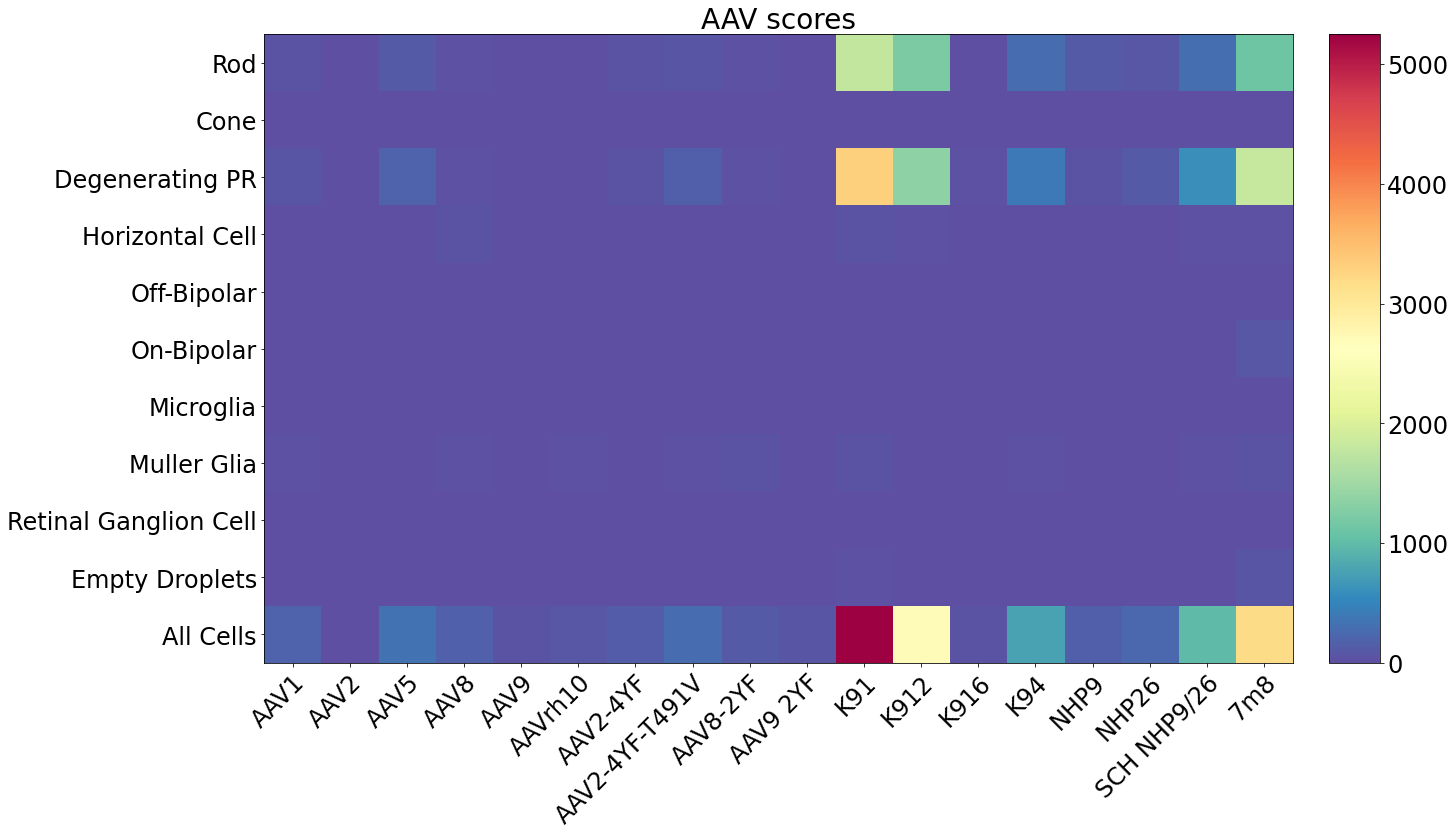

In [122]:
# Heatmap of cells infected

heatmap = mergeddf

cell_order = ['Rod','Cone','Degenerating PR','Horizontal Cell','Off-Bipolar',
              'On-Bipolar','Microglia','Muller Glia','Retinal Ganglion Cell',
             'Empty Droplets','All Cells']

aav_order = ['AAV1','AAV2','AAV5','AAV8','AAV9','AAVrh10','AAV2-4YF','AAV2-4YF-T491V','AAV8-2YF','AAV9 2YF','K91','K912','K916','K94','NHP9','NHP26','SCH NHP9/26','7m8']

heatmap = heatmap.reindex(columns=cell_order)
heatmap = heatmap.reindex(index=aav_order)
heatmap = heatmap.reindex(index=heatmap.index[::-1])

plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
fig, ax = plt.subplots()
im = ax.imshow(heatmap.transpose().values, cmap=cmap_reversed)

ax.set_xticks(np.arange(18))
ax.set_yticks(np.arange(11))
ax.set_xticklabels(heatmap.index)
ax.set_yticklabels(heatmap.columns)
ax.set_ylim(10.5, -0.5)
ax.set_xlim(17.5, -0.5)
ax.set_title("AAV scores",fontsize=28)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.5)
plt.colorbar(im, cax=cax)


plt.show()

In [129]:
plotdf=pd.DataFrame(index=adata.obs_names,columns=adata.var_names.values)
plotdf

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,...,AC133551.1,AC136612.1,AC136616.1,AC136616.3,AC136616.2,AC141272.1,AC023491.2,AC007325.1,AC007325.4,AC007325.2
AAACCCAGTAAGGAGA-1_1_macula-macula1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACCCATCTAGGCCG-1_1_macula-macula1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACGAAGTGGCTCTG-1_1_macula-macula1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGGATCACGGTCTG-1_1_macula-macula1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAGGGCGTCATCCCT-1_1_macula-macula1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCAGTCG-1_2_macula-macula2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGGTAACTAAG-1_2_macula-macula2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGGTCGAACAG-1_2_macula-macula2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TTTGTTGTCATGGTAC-1_2_macula-macula2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
plotdf['cell_type']=adata.obs['cell_type']
plotdf['umap1']=adata.obsm['X_umap'][:,0]
plotdf['umap2']=adata.obsm['X_umap'][:,1]


In [130]:
adata.obs

,batch,leiden,mark,cell_type
AAACCCAGTAAGGAGA-1_1_macula-macula1,macula1,5,False,Rod
AAACCCATCTAGGCCG-1_1_macula-macula1,macula1,0,False,Degenerating PR
AAACGAAGTGGCTCTG-1_1_macula-macula1,macula1,4,False,Off-Bipolar
AAAGGATCACGGTCTG-1_1_macula-macula1,macula1,0,False,Degenerating PR
AAAGGGCGTCATCCCT-1_1_macula-macula1,macula1,5,False,Rod
...,...,...,...,...
TTTGGTTTCGCAGTCG-1_2_macula-macula2,macula2,2,False,On-Bipolar
TTTGTTGGTAACTAAG-1_2_macula-macula2,macula2,6,False,Muller Glia
TTTGTTGGTCGAACAG-1_2_macula-macula2,macula2,1,False,Rod
TTTGTTGTCATGGTAC-1_2_macula-macula2,macula2,11,False,Off-Bipolar


In [134]:
celltype2color = {"AAV":"#000000","Degenerating PR":"#FF6666","Cone":"#FF9933","Horizontal Cell":"#FFCC33","Microglia":"#66CC33","Muller Glia":"#99FF99","Off-Bipolar":"#33CCFF","On-Bipolar":"#0066FF","Retinal Ganglion Cell":"#6633CC","Rod":"#CC33CC", "Empty Droplets":"#BDBDBD"}


In [135]:

point_order = ['Rod','Cone','Degenerating PR','Horizontal Cell','Off-Bipolar','On-Bipolar',
               'Microglia','Muller Glia','Retinal Ganglion Cell','Empty Droplets']


order_cat = pd.Categorical(plotdf['cell_type'], categories=point_order)
plotdf['order_cat'] = order_cat
order_cat

['Rod', 'Degenerating PR', 'Off-Bipolar', 'Degenerating PR', 'Rod', ..., 'On-Bipolar', 'Muller Glia', 'Rod', 'Off-Bipolar', 'Off-Bipolar']
Length: 4814
Categories (10, object): ['Rod', 'Cone', 'Degenerating PR', 'Horizontal Cell', ..., 'Microglia', 'Muller Glia', 'Retinal Ganglion Cell', 'Empty Droplets']

In [136]:
plotdf = plotdf.sort_values('order_cat',ascending=False)

In [138]:
from plotnine import *


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


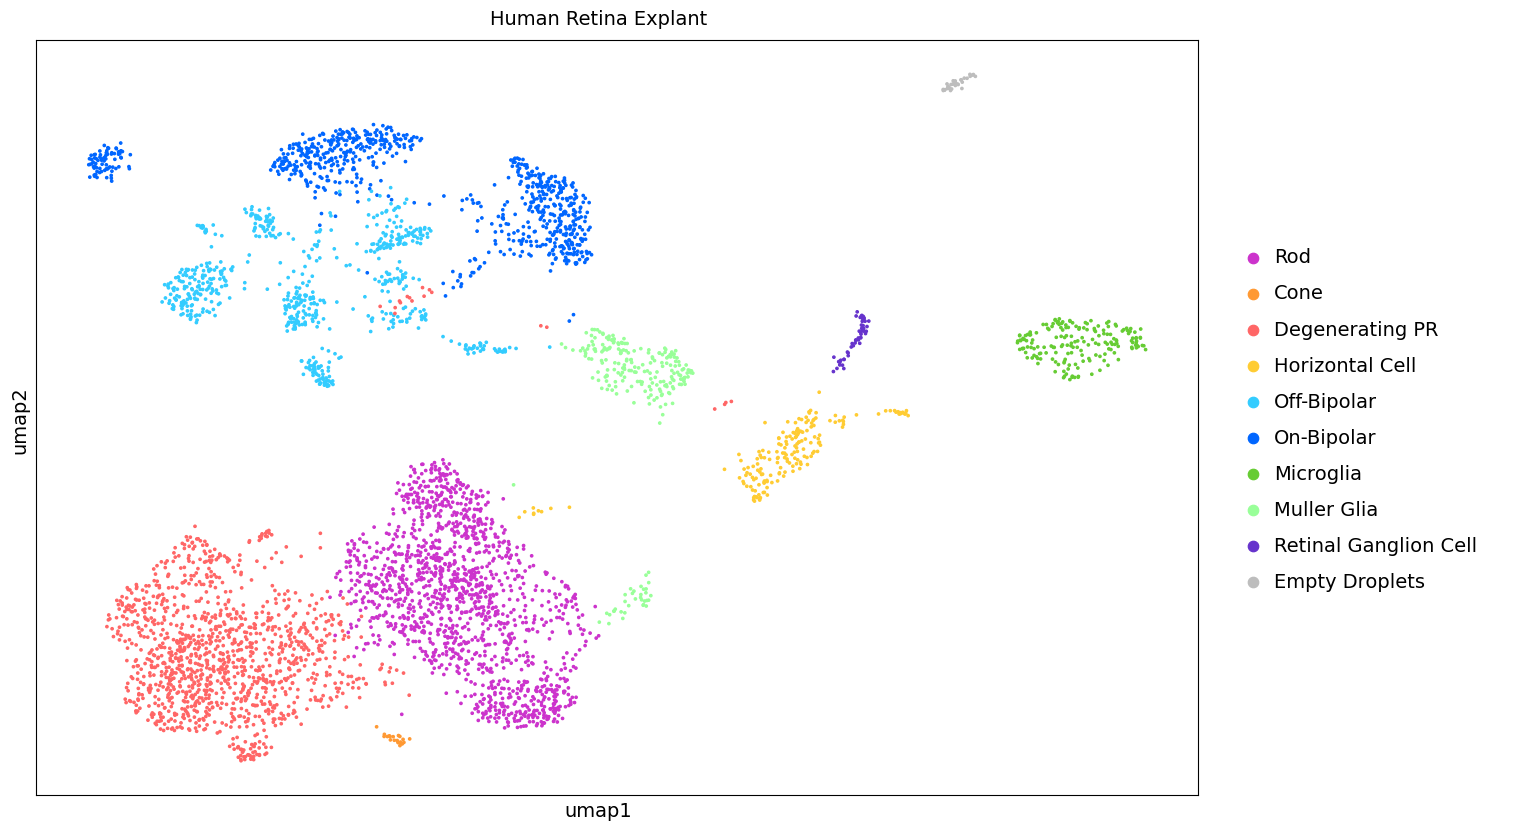

<ggplot: (8739212491545)>

In [139]:
theme_set(theme_matplotlib())
ggplot(plotdf,aes(x="umap1",y="umap2",color="order_cat")) + \
    geom_point(shape=".",) + \
    theme(figure_size=(15,10),axis_ticks=element_blank(),axis_text=element_blank(),legend_title=element_blank(),text=element_text(size=14, family="Arial")) + \
    ggtitle("Human Retina Explant") + \
    scale_color_manual(celltype2color) + \
    guides(color=guide_legend(override_aes={"size":8}),size=None) 


In [140]:
# add AAV info
### first add aav to cell type info (for coloring purposes)

cell_type_with_aav = []
for x in plotdf.index.values:
    if x in cells_infected:
        cell_type_with_aav.append("AAV")
    else:
        cell_type_with_aav.append(plotdf.loc[x,"cell_type"])
        

plotdf['cell_type_with_aav']=cell_type_with_aav


### then, add aav_size to make geom points larger for aav
# if cell contains aav --> geom point will be size 5
# else geom point will be normal (size 1)
aav_size = []
for x in plotdf.index.values:
    if x in cells_infected:
        aav_size.append(5)
    else:
        aav_size.append(5)
        
plotdf['aav_size']=aav_size


In [145]:
cell_type_with_aav

['Empty Droplets',
 'Empty Droplets',
 'AAV',
 'Empty Droplets',
 'Empty Droplets',
 'AAV',
 'AAV',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'AAV',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'AAV',
 'Empty Droplets',
 'AAV',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'AAV',
 'Empty Droplets',
 'AAV',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'Empty Droplets',
 'AAV',
 'Retinal Ganglion Cell',
 'AAV',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'AAV',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'Retinal Ganglion Cell',
 'AAV',
 'Retinal Ganglion Cell',
 'AAV',


In [146]:

point_order = ['AAV','Rod','Cone','Degenerating PR','Horizontal Cell','Off-Bipolar','On-Bipolar',
               'Microglia','Muller Glia','Retinal Ganglion Cell','Empty Droplets']


order_cat = pd.Categorical(plotdf['cell_type_with_aav'], categories=point_order)
plotdf['order_cat'] = order_cat
order_cat

['Empty Droplets', 'AAV', 'AAV', 'Empty Droplets', 'Empty Droplets', ..., 'AAV', 'AAV', 'Rod', 'Rod', 'AAV']
Length: 4814
Categories (11, object): ['AAV', 'Rod', 'Cone', 'Degenerating PR', ..., 'Microglia', 'Muller Glia', 'Retinal Ganglion Cell', 'Empty Droplets']

In [147]:
plotdf = plotdf.sort_values('order_cat',ascending=False)

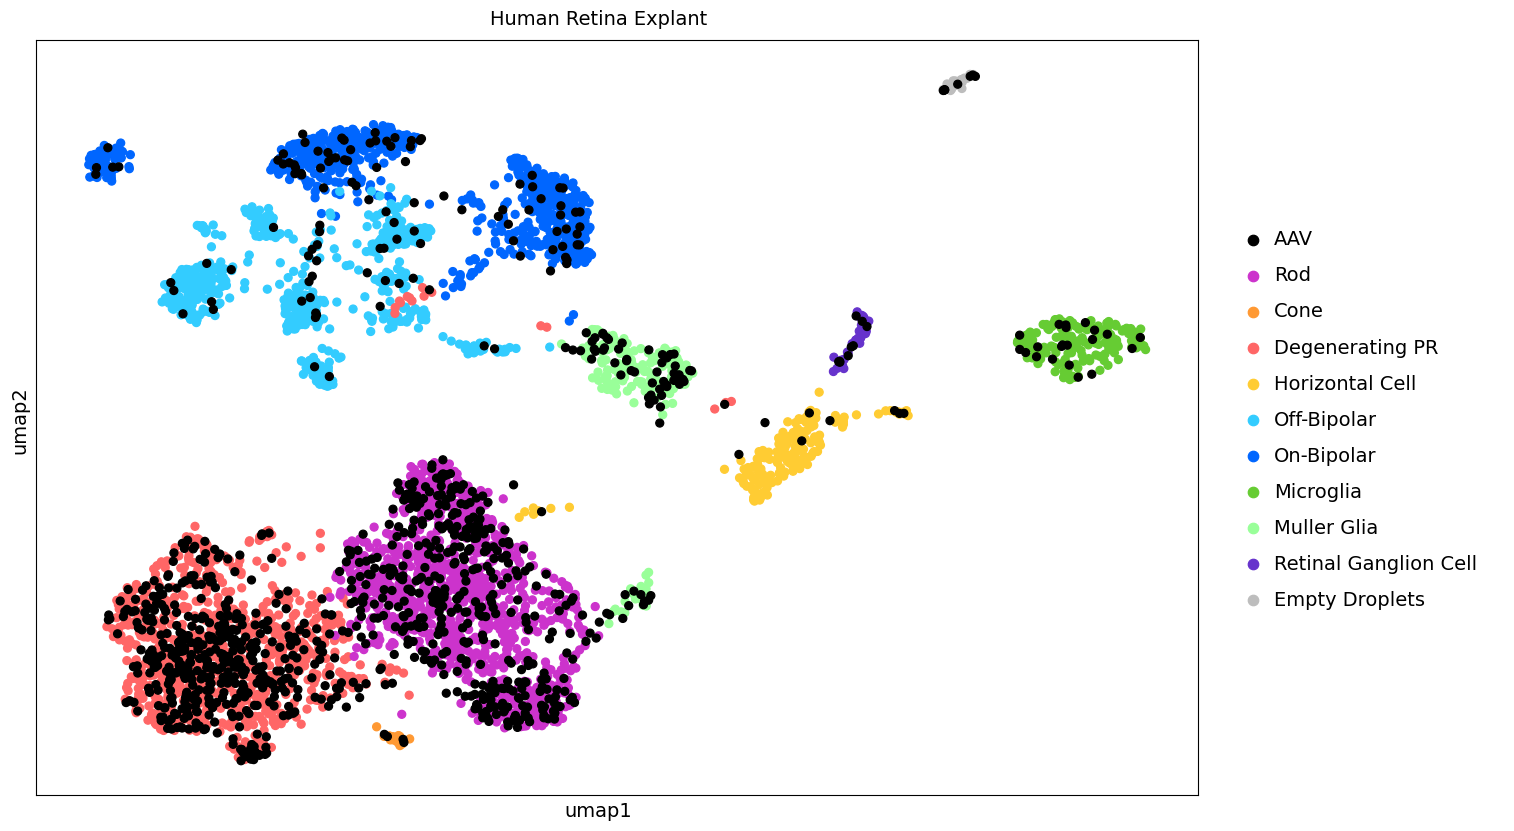

<ggplot: (8739272897997)>

In [148]:
theme_set(theme_matplotlib())
ggplot(plotdf,aes(x="umap1",y="umap2",color="order_cat")) + \
    geom_point(aes(size='aav_size'),shape=".",) + \
    theme(figure_size=(15,10),axis_ticks=element_blank(),axis_text=element_blank(),legend_title=element_blank(),text=element_text(size=14, family="Arial")) + \
    ggtitle("Human Retina Explant") + \
    scale_color_manual(celltype2color) + \
    guides(color=guide_legend(override_aes={"size":8}),size=None) 
